# GODAS
https://catalog.pangeo.io/browse/master/ocean/GODAS/

https://www.psl.noaa.gov//data/gridded/data.godas.html

In [ ]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [ ]:
client

In [ ]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
ds = xr.open_zarr(mapping, consolidated=True)

In [4]:
ds

<xarray.Dataset>
Dimensions:    (lat: 417, lat_u: 417, level: 40, level_w: 40, lon: 360, lon_u: 360, time: 471)
Coordinates:
  * lat        (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.83 64.17 64.5
  * lat_u      (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67
  * level      (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * level_w    (level_w) float32 10.0 20.0 30.0 ... 4.225e+03 4.736e+03
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lon_u      (lon_u) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
Data variables:
    dbss_obil  (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    dbss_obml  (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    dzdt       (time, level_w, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    pottmp     (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    salt       (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    sltfl      (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    sshg       (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    thflx      (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    ucur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    uflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    vcur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    vflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
Attributes:
    Conventions:      COARDS
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    grib_file:        godas.M.198001-12.grb
    history:          Created 2006/12 by Hoop
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    title:            GODAS: Global Ocean Data Assimilation System

In [6]:
#Changing longitude coords from 0:360 to -180:180
ds_roll = ds.roll(lon=-180).copy()
ds_roll_drop_lon = ds_roll.drop('lon')
lon = ds_roll.lon.data
lon[lon>180.] -= 360.
ds_roll_drop_lon.coords['lon'] = ('lon', lon)
ds_roll_drop_lon.lon

ds_roll_u = ds_roll_drop_lon.roll(lon_u=-180).copy()
ds_roll_drop_lon_u = ds_roll_u.drop('lon_u')
lon_u = ds_roll_u.lon_u.data
lon_u[lon_u>180.] -= 360.
ds_roll_drop_lon_u.coords['lon_u'] = ('lon_u', lon_u)

<ipython-input-6-faf756f2a2d8>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll = ds.roll(lon=-180).copy()
<ipython-input-6-faf756f2a2d8>:9: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll_u = ds_roll_drop_lon.roll(lon_u=-180).copy()


In [7]:
coords = ds_roll_drop_lon_u.coords.to_dataset().reset_coords()
ds = ds_roll_drop_lon_u.reset_coords(drop=True)

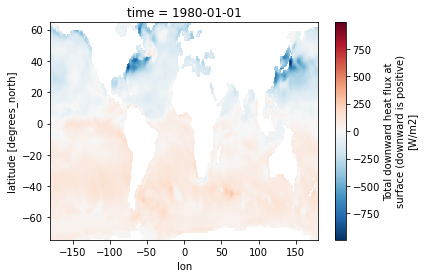

In [8]:
ds.thflx[0].plot()

In [9]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-74.16667˚S
upper_lat = 37 #-61.83˚S
left_lon =  115 #64.5˚W
right_lon = 210 #30.5˚E

lower_lat_u = 0 #-74.0
upper_lat_u = 37 #-61.67 python is left exclusive so will have -62.0 in array
left_lon_u = 114 #65.0˚W 
right_lon_u = 210 #31.0˚E python is left exclusive so will have 30.0˚E

In [10]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat), lat_u=slice(lower_lat_u, upper_lat_u))
lon_range = dict(lon=slice(left_lon, right_lon), lon_u=slice(left_lon_u, right_lon_u))

lat_range_no_face = dict(lat=slice(lower_lat, upper_lat))
lon_range_no_face = dict(lon=slice(left_lon, right_lon))

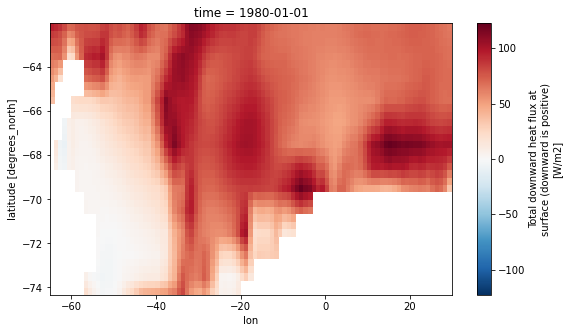

In [11]:
ds.thflx[0].isel(**lat_range_no_face, **lon_range_no_face).plot(figsize=(9,5))

In [12]:
ds_wg = ds.isel(**lat_range, **lon_range)
coords_wg = coords.isel(**lat_range, **lon_range)

#### What can we compute with GODAS ds?
- [ ] surf flux
- [ ] sw flux
- [ ] adv flux
- [ ] transport at boundaries
- [ ] diff flux
- [ ] total tendency

## <font color='Green'>Get Lat/Lon in meters</font>

In [13]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [14]:
#converting degrees lat to lat [meters]
delta_lat = coords_wg.lat.diff('lat')
dy = delta_lat * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = 1
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(coords_wg.lat))

cell_area = dx * dy

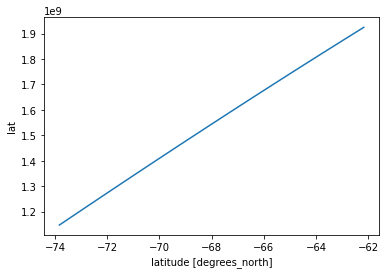

In [96]:
cell_area.plot()

## <font color='Green'>\begin{equation*} Surface\ Flux \end{equation*}</font>

In [15]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = ds_wg.thflx * cell_area / (heat_capacity_cp * runit2mass)

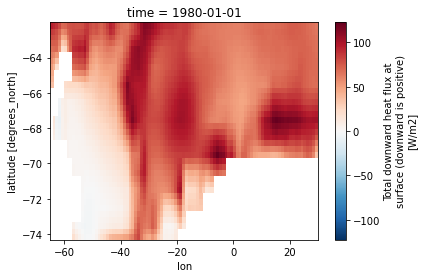

In [16]:
ds_wg.thflx[0].plot()

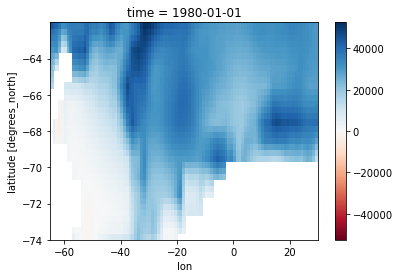

In [17]:
surf_flux_th[0].plot(cmap='RdBu')

## <font color='Green'>\begin{equation*} \Psi_{vel} at boundary\end{equation*}</font>

In [ ]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

u_transport_left[0].plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT')
u_transport_right[0].plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT')
v_transport[0].drop('lon_u').plot(yincrease=False, ax=ax2)
ax2.set_title('V transport');

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>

In [66]:
dt_values = (np.diff(ds_wg.time) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds_wg.time.values[0:-1])})
coords_wg.coords['dt'] = dt

In [39]:
#calculating total tendency termdtyper heat
delta_theta = ds_wg.pottmp.diff('time')

In [62]:
delta_theta

<xarray.DataArray 'pottmp' (time: 470, level: 40, lat: 37, lon: 95)>
dask.array<sub, shape=(470, 40, 37, 95), dtype=float32, chunksize=(3, 40, 37, 95), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-03-01
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
    dt       (time) float32 2.506e+06 2.678e+06 2.592e+06 ... 2.419e+06 nan

In [68]:
#forcing delta_theta to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','level','lat','lon'], 
                            coords={'time': coords.dt[1:471].time.data})
delta_theta

<xarray.DataArray 'sub-7a1c8007b93934c059eeaab1b34afe90' (time: 470, level: 40, lat: 37, lon: 95)>
dask.array<sub, shape=(470, 40, 37, 95), dtype=float32, chunksize=(3, 40, 37, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-03-01
Dimensions without coordinates: level, lat, lon

In [79]:
delta_theta

<xarray.DataArray 'sub-7a1c8007b93934c059eeaab1b34afe90' (time: 470, level: 40, lat: 37, lon: 95)>
dask.array<sub, shape=(470, 40, 37, 95), dtype=float32, chunksize=(3, 40, 37, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-03-01
Dimensions without coordinates: level, lat, lon

In [80]:
theta_tend = (delta_theta / coords_wg.dt[1:])

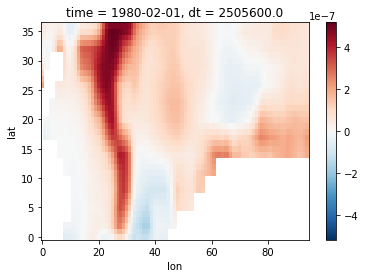

In [82]:
theta_tend[0,0].plot()